# Schwinger Model
A notebook for the (1+1)-d Schwinger model

## Imports

In [1]:
import math
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from qiskit.quantum_info import SparsePauliOp, Statevector
from qiskit.visualization import array_to_latex
import matplotlib.pyplot as plt
import functools as ft
from schwinger_hamiltonian import *

# Classical Schwinger

## Hamiltonian

In [2]:
# Hamiltonian Parameters 
N=4
t=9.8
ti=0.2
m=1.1
a=1.2
g=1.3

# Hamiltonian construction in schwinger_hamiltonian.py
array_to_latex(Ham_Schwinger_Bos(N, t, ti, m, a, g))

<IPython.core.display.Latex object>

In [3]:
array_to_latex(Ham_Schwinger_Spin(N, t, ti, m, a, g))

<IPython.core.display.Latex object>

In [4]:
np.all(np.equal(Ham_Schwinger_Bos(N, t, ti, m, a, g), Ham_Schwinger_Spin(N, t, ti, m, a, g)))

True

# Free theory

## Free massless theory

The first thing we can do is compute the full spectrum of the Hamiltonian by solving the eigenystem. Note all states with negative energy are filled states whereas all states greater than zero are empty states.  

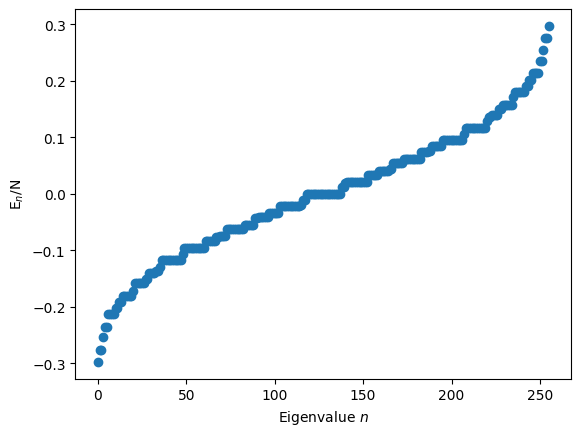

In [5]:
import math

N=8
t=0
ti=0
m=0
a=1
g=0

H = Ham_Schwinger_Spin(N, t, ti, m, a, g)
evals,evecs = np.linalg.eig(H) #Directly computes eigenvalues of H
nevals = evals/N
xvals = np.array(range(len(nevals)))
#plt.plot(xvals,evals.real)
plt.scatter(xvals, np.sort(nevals.real))
plt.xlabel("Eigenvalue $n$")
plt.ylabel("E$_n$/N")
plt.show()


Applying a discrete fourier transform (DFT) to the continuum Hamiltonian it can shown the single-particle dispersion relation is $\varepsilon_k = \cos(k_n)$, with $k_n = \pi \left(\frac{2n+1}{N a} \right)$, $n = 0, \pm 1, ..., \pm N$

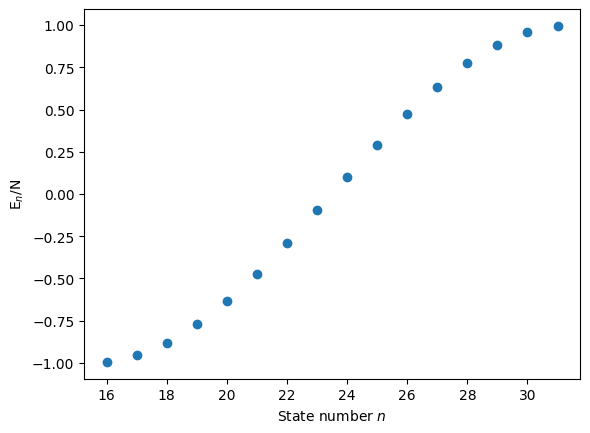

In [6]:
N=32
t=0
ti=0
m=0
a=1
g=0

xdata = []
ydata = []
norm = np.sort(nevals.real)[0]
for n in range(16, 32):
    xdata.append(n)
    #ydata.append(norm*math.cos((np.pi*(2*i*np.pi/len(nevals))/N)))
    ydata.append(math.cos(np.pi*(2*n+1)/(N*a)))

plt.scatter(xdata, ydata)
plt.xlabel("State number $n$")
plt.ylabel("E$_n$/N")
plt.show()

## Time evolution

Time evolution is given by $|\Psi_t \rangle = \mathcal{T} e^{-i \int_0^t dt' H(t')} |\Psi_0 \rangle$, where $|\Psi_0 \rangle$ is the $H(t=0)$ vacuum state and $\mathcal{T}$ indicates time ordering.

## Charge Identification (Schmidt vectors)

To verify we can identify the charges, we aim to reproduce Figure 4 of 2404.00087, which details the evolution of the electric charge distribution in the leading Schmidt vectors.

1. Identify the time-evolved wavefunction $|\Psi_t \rangle$ used to construct the full density matrix $\rho = |\Psi_t \rangle \langle \Psi_t |$. 

2. Compute the left (or right) reduced density matrix by tracing out the right (or left) subsystem: $\rho_L(t) = \text{Tr}_R \rho(t) = \sum_i \lambda_i(t) |\psi^L_i (t) \rangle \langle \psi^L_i (t)|$. We can do this because any bipartate state has a Schmidt decomposition $|\Psi_t \rangle = \sum_{i=1}^{d} \sqrt{\lambda_i(t)} |\psi^L_i (t) \rangle \, |\psi^R_i (t) \rangle$, where $d=\text{min}(\text{dim}(d_L), \text{dim}(d_R))$, $\lambda_i \geq 0$, and $\{ | \psi^L_i \rangle \}, \{ | \psi^R_i \rangle \}$ are the collections of the orthonormal basis vectors (Schmidt vectors) for the left and right reduced density matrices, respectively. The coefficients $\sqrt{\lambda_i}$ are the Schmidt coefficients.

3. After calculating the reduced density matrix $\rho_L(t)$ and finding the eigenvalues and eigenvectors (Schmidt vectors), we need to construct the right (left) Schmidt vectors appropriately to be able to recreate the initial state. Note this means setting the phase degree of freedom afforded by the fact we can always multiply $|\psi^L_i \rangle$ by $e^{i \theta}$ and $|\psi^R_i \rangle$ by $e^{-i \theta}$ in the Schmidt decomposition.


In [7]:
# Array manipulation helper functions
def Swap_col(arr, start_index, last_index):
    arr[:, [start_index, last_index]] = arr[:, [last_index, start_index]]
    return arr

def Swap_row(arr, start_index, last_index):
    arr[ [start_index, last_index], :] = arr[[last_index, start_index], :]
    return arr

def Swap_pos(lis, pos1, pos2):
    temp=lis[pos1]
    lis[pos1]=lis[pos2]
    lis[pos2]=temp
    return lis


# Schmidt decomposition using SVD
def schmidt_decomposition_pure_state(in_state):
    """
        state : numpy vector state
        decomposition_shape : tuple of integers of dims of two subsystems
        
        sc  : numpy vector of Schmidt coefficients
        slv : left Schmidt vectors
        srv : right Schmidt vectors
    """
    
    #decomposition_shape = (int(np.log2(len(in_state))), int(np.log2(len(in_state))))
    #decomposition_shape = (int(2**(N/2)), int(2**(N/2)))
    decomposition_shape = (int(np.sqrt(len(in_state))), int(np.sqrt(len(in_state))))
    d1, d2 = decomposition_shape
    m = in_state.reshape(d1, d2)
    slv, sc, srv = np.linalg.svd(m, full_matrices=True)

    # Because the SVD is not unique, we need to make sure we get back the original vector. 
    # This comes from the fact that neither eigenvectors of an eigenspace 
    # are unique, nor are their labeling. Here there is a sign ambiguity that disappears 
    # when calculating A = U @ S @ V.T in the usual SVD. Our solution is not the most 
    # efficient but makes the most logical sense: simply swap around columns of the 
    # Schmidt vectors until we can reproduce the original state up to a sign; if needed, 
    # correct the negative sign.

    count = 0
    for i in range(len(sc)):
        find = False
        phase = False
        for j in range(len(sc)):
            Swap_pos(sc, i, j)
            #Swap_row(slv, i, j)
            Swap_row(srv, i, j)
            out_state_temp = 0
            for i in range(len(sc)):
                out_state_temp += sc[i]*np.einsum('i,j', slv[i], srv[i]).reshape(1,len(in_state))[0]

            if (np.all(np.isclose(out_state_temp, in_state)) == True):     # Directly equal
                i_final = i
                j_final = j
                find = True
                break

            if (np.all(np.isclose(out_state_temp, -in_state)) == True):     # Equal up to phase (minus sign)
                i_final = i
                j_final = j
                find = True
                phase = True
                break
        if find:
            break
        count += 1
        if(count > math.factorial(len(in_state+1))):     # Despite all permutations does not find the correct answer
            print("Rearrangement failed.")
            break
    # If found off by a negative sign, fix it.
    if phase:    
        srv = -1 * srv

    return sc, slv, srv

### Figure 4

First calculate the vacuum state of the system, then time-evolve, if desired. 

In [93]:
N=6
t=0
ti=0
m=2
a=1
g=1/2

H = Ham_Schwinger_Spin(N, t, ti, m, a, g)
vacuum_evals, vacuum_evecs = np.linalg.eig(H) #Directly computes eigenvalues of H
#vacuum_evals, vacuum_evecs = sp.sparse.linalg.eigsh(H, which='SA',k=N)

idx = np.argsort(vacuum_evals)[::1]
vacuum_evals_sorted = vacuum_evals[idx]     # Sorts eigenvalues from smallest to largest
vacuum_evecs_sorted = vacuum_evecs[:,idx]   # Sorts eigenvectors from smallest to largest eigenvalue

ground_wf = vacuum_evecs_sorted[0]          # Ground state wavefunction corresponds to smallest eigenvalue

array_to_latex(H)

<IPython.core.display.Latex object>

In [94]:
array_to_latex(vacuum_evals_sorted)

<IPython.core.display.Latex object>

The total charge in each subsystem is defined by $\sum_{n=1}^{N/2} q_n | \psi^L_i \rangle \equiv Q_L |\psi^L_i \rangle$, and similarly for $Q_R$. Time-dependent expectation values are computed from the usual definition $\langle O \rangle_t \equiv \langle \Psi_t | O | \Psi_t \rangle$. The local electric charge of the $i$-th Schmidt vector at the lattice site $n$ is therefore given by $\langle \psi^L_i | q_n | \psi^L_i \rangle$.

Check that we get back the input state $|\Psi \rangle$ from the Schmidt decomposition $|\Psi \rangle = \sum_{i=1}^{d} \sqrt{\lambda_i} |\psi^L_i  \rangle \, |\psi^R_i  \rangle$.

In [95]:
in_state = ground_wf
sc, slv, srv = schmidt_decomposition_pure_state(in_state)

# Construct original wavefunction from the output Schmidt decomposition data 
out_state = 0
for i in range(len(sc)):
    out_state += sc[i]*np.einsum('i,j', slv[i], srv[i]).reshape(1, len(in_state))[0]

#print(in_state)
#print(out_state)
np.all(np.isclose(out_state, in_state))


True

Schmidt vectors can have non-zero charge, so long as the sum of $Q_L + Q_R = 0$, where $\sum_{n=1}^{N/2} q_n | \psi^L_i \rangle \equiv Q_L |\psi^L_i \rangle$, and similarly for $Q_R$.

In [96]:
left_charge_matrix = []
right_charge_matrix = []
total_charge_matrix = []


sd_lv_sorted = slv
sd_rv_sorted = srv

#index = 2**int(N/2)           
index = int(N)     # Number of Schmidt vectors
for ix in range(index):
    local_charge_left = []
    local_charge_right = []
    total_charge = []
    for i in range(1, int(N/2)+1):
        lc_left = sd_lv_sorted[ix] @ Local_Charge_Left(int(N), i) @ sd_lv_sorted[ix]
        #print(ix)
        #print(i)
        lc_right = sd_rv_sorted[ix] @ Local_Charge_Right(int(N), i) @ sd_rv_sorted[ix]
        local_charge_left.append(lc_left)
        local_charge_right.append(lc_right)
        total_charge.append(lc_left + lc_right)
    left_charge_matrix.append(local_charge_left)
    right_charge_matrix.append(local_charge_right)
    total_charge_matrix.append(total_charge)

#print(left_charge_matrix)
#print(right_charge_matrix)
#print(total_charge_matrix)
np.array(total_charge_matrix).reshape(1,int(N*N/2)).sum()

0j

Plot it like Figure 4.

Text(0.5, 1.0, '$N=6, m=2, g=0.5, a=1, t=0$')

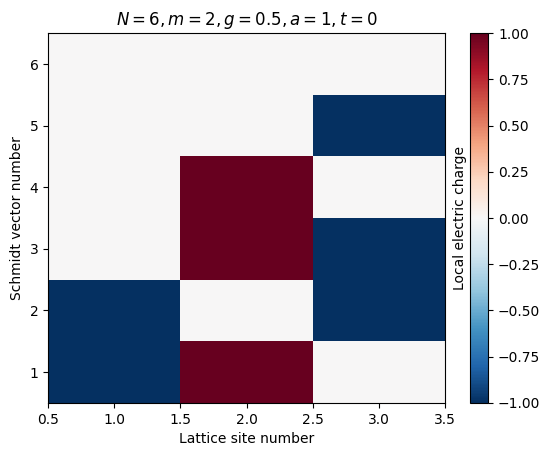

In [97]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm

# Relabel  
temp = np.array(left_charge_matrix)
temp[[0, 2], :] = temp[[2, 0], :]
temp[[1, 3], :] = temp[[3, 1], :]
temp[[2, 4], :] = temp[[4, 2], :]

xlimit = len(left_charge_matrix[0])
ylimit = len(left_charge_matrix)

x = np.linspace(1, xlimit, xlimit)
y = np.linspace(ylimit, 1, ylimit)
x,y = np.meshgrid(x,y)

z = np.real(temp)

fig,ax = plt.subplots()
mesh = ax.pcolormesh(x,y,z, vmin=-1, vmax=1, cmap = cm.RdBu_r, linewidth=10,rasterized=True)
cbar = fig.colorbar(mesh)
cbar.set_label('Local electric charge', labelpad=-63,  rotation=90,)
#plt.gca().invert_yaxis()

plt.xlabel(r'Lattice site number')
plt.ylabel('Schmidt vector number')
plt.title(r'$N=6, m=2, g=0.5, a=1, t=0$')

# Quantum Schwinger Model

Ultimately our goal is simulate this on the quantum hardware. To do this, the following steps must occur: 

1. First we need to input the Hamiltonian into Qiskit successfully using the Hamiltonian from the Jordan-Wigner transformation, which is solely in terms of Pauli operators. 
2. Next we need to Trotterize the circuit to be able to perform time evolution.
3. We need to map the circuit to hardware in way to minimize errors.

## Spin representation Hamiltonian

To put the model on the quantum hardware we need to describe the Hamiltonian in terms of Pauli operators. Applying the Jordan-Wigner transformation, 

\begin{align}
\chi_n &= \frac{X_n - i Y_n}{2} \prod_{j<n} (i Z_j) \, ,  \\
\chi^{\dagger}_n &= \frac{X_n + i Y_n}{2} \prod_{j<n} (-i Z_j) \, ,
\end{align}

the (staggered fermion, OBC) Schwinger model on the lattice becomes

\begin{align}
H = \frac{1}{4a}\sum_{n=1}^{N-1} \left[X_n X_{n+1} + Y_n Y_{n+1} \right] 
  + \frac{m}{2} \sum_{n=1}^N (-1)^n Z_n   
  + \frac{g^2 a}{2} \sum_{n=1}^{N-1} \left[ \sum_{j=1}^n \left( \frac{Z_j + (-1)^j}{2}  \right) - \theta \left( \frac{t-t_0}{a} 
  - \left| n - \frac{N}{2}  \right|     \right)   \right]^2 \, .
\end{align}

This spin representation form of the lattice Schwinger model is advantageous as it can be directly simulated on the quantum hardware. First we check that the two forms are indeed equivalent.

In [2]:
import math
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from qiskit.quantum_info import SparsePauliOp, Statevector
from qiskit.visualization import array_to_latex
import matplotlib.pyplot as plt
import functools as ft
from schwinger_hamiltonian import *

In [99]:
# Hamiltonian parameters 
N=4
t=0 
ti=0
m=1.1
a=1.2
g=1.3

# Hamiltonian constructions in schwinger_hamiltonian.py
print(np.all(np.isclose(Ham_Schwinger_Pauli(N, t, ti, m, a, g).to_matrix(), Ham_Schwinger_Spin(N, t, ti, m, a, g))))
print(np.all(np.isclose(Ham_Schwinger_Pauli(N, t, ti, m, a, g).to_matrix(), Ham_Schwinger_Bos(N, t, ti, m, a, g))))
print(np.all(np.isclose(Ham_Schwinger_Spin(N, t, ti, m, a, g), Ham_Schwinger_Bos(N, t, ti, m, a, g))))

True
True
True


We see that all the forms of the Hamiltonian are equivalent. The advantage of the Pauli form is that everything is left in terms of Pauli operators, which are native to quantum software and hardware. 

In [102]:
# Explicit Pauli form of the Hamiltonian 
Ham_Schwinger_Pauli(N, t, ti, m, a, g)

SparsePauliOp(['XXII', 'YYII', 'IXXI', 'IYYI', 'IIXX', 'IIYY', 'ZIII', 'IZII', 'IIZI', 'IIIZ', 'IIII', 'ZIII', 'ZZII', 'ZIZI', 'IZZI', 'IZII', 'IIZI'],
              coeffs=[ 0.20833333+0.j,  0.20833333+0.j,  0.20833333+0.j,  0.20833333+0.j,
  0.20833333+0.j,  0.20833333+0.j, -0.55      +0.j,  0.55      +0.j,
 -0.55      +0.j,  0.55      +0.j,  2.028     +0.j, -1.014     +0.j,
  1.014     +0.j,  0.507     +0.j,  0.507     +0.j, -0.507     +0.j,
 -0.507     +0.j])

# Quantum Simulation

### Imports for accessing the hardware

In [103]:
from qiskit import QuantumRegister, ClassicalRegister
from qiskit_ibm_runtime import EstimatorV2 as Estimator
from qiskit import transpile
#from qiskit.tools import job_monitor
from qiskit_aer import AerSimulator
import numpy as np


from qiskit_aer import AerSimulator
aer_sim = AerSimulator()
backend = aer_sim

from qiskit_ibm_provider import IBMProvider
provider = IBMProvider(token='')

#aer_sim = AerSimulator()
#backend = aer_sim
backend = provider.get_backend("ibm_rensselaer")


estimator = Estimator(backend=backend)

Helper functions to create and transpile circuits using PauliEvolutionGate.

In [104]:
from qiskit.circuit import QuantumCircuit
from qiskit.synthesis import SuzukiTrotter
from qiskit.circuit.library import PauliEvolutionGate
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit.converters import circuit_to_dag

def make_circuit(Ham, suzuki_order, evol_time):
    circ = QuantumCircuit(Ham.num_qubits) 
    evo_op = PauliEvolutionGate(Ham, evol_time, synthesis=SuzukiTrotter(order=suzuki_order, reps=1))
    circ.append(evo_op.definition, list(range(Ham.num_qubits)))
    return circ

def transpile_circuit(circ, optimization_level=1, coupling_map=None): 
    pm = generate_preset_pass_manager(backend=backend, optimization_level=optimization_level, coupling_map=coupling_map)
    tcirc = pm.run(circ)
    return tcirc

def count_number_of_qubits(circ):
    dag = circuit_to_dag(circ)
    num_idle_qubits = len(list(dag.idle_wires()))
    return circ.num_qubits - num_idle_qubits

### Make the circuit

In [105]:
N=4
t=0
ti=0
m=1
a=1
g=0

Ham = Ham_Schwinger_Pauli(N, t, ti, m, a, g)

circ = make_circuit(Ham, suzuki_order=2, evol_time=0.1)
tcirc = transpile_circuit(circ, optimization_level=3, coupling_map=[[0,1],[1,2],[2,3],[3,4]])
print(f'num_qubits = {count_number_of_qubits(tcirc)}, two-qubit depth = {tcirc.depth(lambda x: x[0].name=="ecr")}')

num_qubits = 4, two-qubit depth = 10


### Always good to look at the circuit

In [106]:
tcirc.decompose(reps=3).draw(fold=-1, idle_wires=False)

global phase: 3.412
         ┌──────────┐  ┌───────────────┐  ┌─────────┐                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        ┌───┐┌─────────┐┌───┐┌─────────┐ ┌─────────┐┌───┐┌──────────┐┌───┐  ┌─────────┐   ┌────────────────┐┌──────────────┐ ┌─────────────┐  ┌──────────────┐ ┌───────────┐   ┌─────────┐                  ┌───┐┌─────────┐┌───┐┌─────────┐ ┌─────────┐┌───┐┌──────────┐┌───┐ ┌─────────┐   ┌───────────┐  ┌──────────────┐┌─────────────┐  ┌──────────────┐┌───────────────┐                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                
q_90: ───┤ U(π,0,π) ├──┤ U(0,0,1.8485) ├──┤ U2(0,π) ├────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤ X ├┤ U1(π/4) ├┤ X ├┤ U2(0,π) ├─┤ U2(0,π) ├┤ X ├┤ U1(-π/4) ├┤ X ├──┤ U2(0,π) ├───┤ U(0,0,-3.0918) ├┤ U3(0,0,-π/2) ├─┤ U3(π/2,0,π) ├──┤ U3(0,0,-π/2) ├─┤ U(0,0,-π) ├───┤ U2(0,π) ├──────────────────┤ X ├┤ U1(π/4) ├┤ X ├┤ U2(0,π) ├─┤ U2(0,π) ├┤ X ├┤ U1(-π/4) ├┤ X ├─┤ U2(0,π) ├───┤ U(0,0,-π) ├──┤ U3(0,0,-π/2) ├┤ U3(π/2,0,π) ├──┤ U3(0,0,-π/2) ├┤ U(0,0,-1.193) ├────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        ┌┴──────────┴┐ └┬──────────────┤┌─┴─────────┴─┐┌────────────

# Resource estimation

See how many Paulis, physical qubits, and what is the two-qubit circuit depth as we scale up the problem size. This helps us determine where the limitations might be in this model on the hardware.

In [210]:
Nlist = list(range(2, 21, 2))
Ham_num_paulis = []
for j,num in enumerate(Nlist):
    Ham = Ham_Schwinger_Pauli(num, 0, 0, 1, 1, 1)
    Ham_num_paulis.append((num, Ham.num_qubits, len(Ham.paulis), len(Ham.simplify())))

In [211]:
Ham_num_paulis

[(2, 2, 6, 5),
 (4, 4, 17, 14),
 (6, 6, 32, 26),
 (8, 8, 51, 43),
 (10, 10, 74, 64),
 (12, 12, 101, 89),
 (14, 14, 132, 118),
 (16, 16, 167, 151),
 (18, 18, 206, 188),
 (20, 20, 249, 229)]

Text(0.5, 1.0, 'Number of Pauli terms in Hamiltonian')

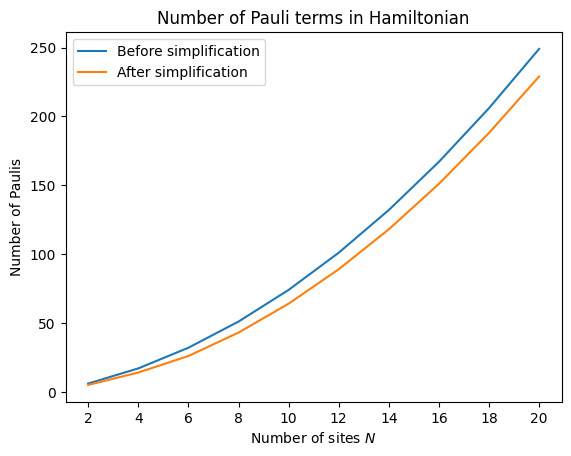

In [369]:
import matplotlib.pyplot as plt
plt.plot(Nlist, [e[2] for e in Ham_num_paulis], label='Before simplification')
plt.plot(Nlist, [e[3] for e in Ham_num_paulis], label='After simplification')
plt.xticks(np.arange(min(nlist), max(nlist)+1, 2))
plt.xlabel(r'Number of sites $N$')
#plt.yscale('log',base=2) 
plt.ylabel('Number of Paulis')
plt.legend()
plt.title(r'Number of Pauli terms in Hamiltonian')

In [406]:
def make_circuit_resource(Ham, suzuki_order, evol_time):
    circ = QuantumCircuit(Ham.num_qubits) 
    evo_op = PauliEvolutionGate(Ham, evol_time, synthesis=SuzukiTrotter(order=suzuki_order, reps=1))
    circ.append(evo_op.definition, list(range(Ham.num_qubits)))
    return circ

def transpile_circuit_resource(circ, backend, optimization_level=3, coupling_map=None): 
    pm = generate_preset_pass_manager(backend=backend, optimization_level=optimization_level, coupling_map=coupling_map)
    tcirc = pm.run(circ)
    return tcirc

backend = provider.get_backend("ibm_rensselaer")

nlist = list(range(2, 22, 2))
num_qubits_list = np.zeros(len(nlist))
depth_list_g0 = np.zeros(len(nlist))
two_depth_list_g0 = np.zeros(len(nlist))
for i,n in enumerate(nlist):
    #for j,p in enumerate(plist):
    print(f'n={n}')
    Ham = Ham_Schwinger_Pauli(n, 0, 0, 1, 1, 0)
    circ = make_circuit_resource(Ham, suzuki_order=2, evol_time=0.2)
    tcirc = transpile_circuit_resource(circ, backend=backend, optimization_level=3, coupling_map=[[0,1],[1,2],[2,3],[3,4]])
    num_qubits_list[i] =  count_number_of_qubits(tcirc)
    depth_list_g0[i] = tcirc.depth()
    two_depth_list_g0[i] = tcirc.depth(lambda x: x[0].name=="ecr")
    print(f'Number of qubits = {num_qubits_list[i]}, Circuit depth = {tcirc.depth()}, Two-qubit depth = {tcirc.depth(lambda x: x[0].name=="ecr")}')

n=2
Number of qubits = 2.0, Circuit depth = 11, Two-qubit depth = 2
n=4
Number of qubits = 4.0, Circuit depth = 48, Two-qubit depth = 10
n=6
Number of qubits = 6.0, Circuit depth = 82, Two-qubit depth = 18
n=8
Number of qubits = 8.0, Circuit depth = 121, Two-qubit depth = 26
n=10
Number of qubits = 10.0, Circuit depth = 154, Two-qubit depth = 34
n=12
Number of qubits = 12.0, Circuit depth = 191, Two-qubit depth = 42
n=14
Number of qubits = 14.0, Circuit depth = 225, Two-qubit depth = 50
n=16
Number of qubits = 16.0, Circuit depth = 262, Two-qubit depth = 58
n=18
Number of qubits = 18.0, Circuit depth = 297, Two-qubit depth = 66
n=20
Number of qubits = 20.0, Circuit depth = 331, Two-qubit depth = 74


Text(0.5, 1.0, 'Two-qubit circuit depth as function of sites (g=0)')

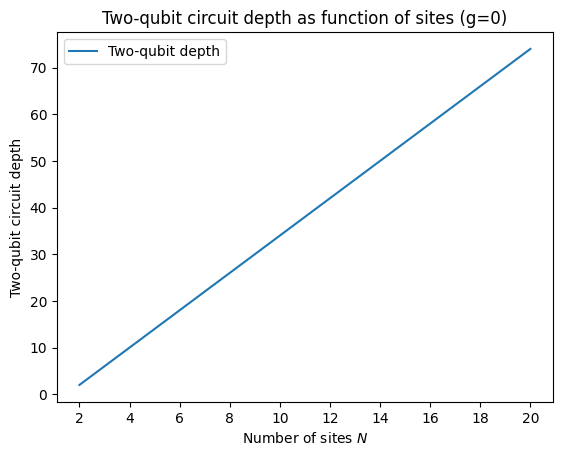

In [407]:
import matplotlib.pyplot as plt
#plt.plot(nlist, [e for e in depth_list], label='Circuit depth')
plt.plot(nlist, [e for e in two_depth_list_g0], label='Two-qubit depth')
plt.xlabel(r'Number of sites $N$')
plt.ylabel('Two-qubit circuit depth')
plt.xticks(np.arange(min(nlist), max(nlist)+1, 2))
#plt.xscale('log',base=2) 
#plt.yscale('log',base=2) 
plt.legend()
plt.title(r'Two-qubit circuit depth as function of sites (g=0)')

In [408]:
nlist = list(range(2, 22, 2))
num_qubits_list = np.zeros(len(nlist))
depth_list_g1 = np.zeros(len(nlist))
two_depth_list_g1 = np.zeros(len(nlist))
for i,n in enumerate(nlist):
    #for j,p in enumerate(plist):
    print(f'n={n}')
    Ham = Ham_Schwinger_Pauli(n, 0, 0, 1, 1, 1)
    circ = make_circuit_resource(Ham, suzuki_order=2, evol_time=0.2)
    tcirc = transpile_circuit_resource(circ, backend=backend, optimization_level=3, coupling_map=[[0,1],[1,2],[2,3],[3,4]])
    num_qubits_list[i] =  count_number_of_qubits(tcirc)
    depth_list_g1[i] = tcirc.depth()
    two_depth_list_g1[i] = tcirc.depth(lambda x: x[0].name=="ecr")
    print(f'Number of qubits = {num_qubits_list[i]}, Circuit depth = {tcirc.depth()}, Two-qubit depth = {tcirc.depth(lambda x: x[0].name=="ecr")}')

n=2
Number of qubits = 2.0, Circuit depth = 12, Two-qubit depth = 2
n=4
Number of qubits = 4.0, Circuit depth = 123, Two-qubit depth = 28
n=6
Number of qubits = 6.0, Circuit depth = 273, Two-qubit depth = 66
n=8
Number of qubits = 8.0, Circuit depth = 622, Two-qubit depth = 147
n=10
Number of qubits = 10.0, Circuit depth = 877, Two-qubit depth = 207
n=12
Number of qubits = 12.0, Circuit depth = 1003, Two-qubit depth = 242
n=14
Number of qubits = 14.0, Circuit depth = 1582, Two-qubit depth = 371
n=16
Number of qubits = 16.0, Circuit depth = 1931, Two-qubit depth = 465
n=18
Number of qubits = 18.0, Circuit depth = 1860, Two-qubit depth = 414
n=20
Number of qubits = 20.0, Circuit depth = 2262, Two-qubit depth = 498


Text(0.5, 1.0, 'Two-qubit circuit depth as function of sites (g=1)')

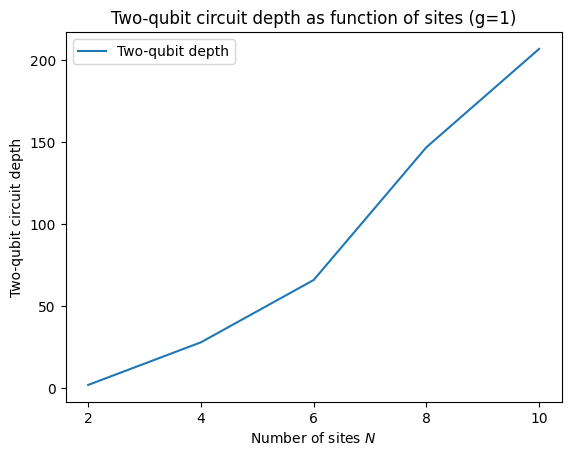

In [413]:
import matplotlib.pyplot as plt
#plt.plot(nlist, [e for e in depth_list], label='Circuit depth')
plt.plot(nlist[0:5], [e for e in two_depth_list_g1[0:5]], label='Two-qubit depth')
plt.xlabel(r'Number of sites $N$')
plt.ylabel('Two-qubit circuit depth')
plt.xticks(np.arange(min(nlist[0:7]), max(nlist[0:5])+1, 2))
#plt.xscale('log',base=2) 
#plt.yscale('log',base=2) 
plt.legend()
plt.title(r'Two-qubit circuit depth as function of sites (g=1)')

The circuit depth and two-qubit depth is approximately a linear function of the number of sites $N$. For $g=1$, at and above $N\geq8$ the two-qubit depth is $>150$, which is too deep to get tractable results on the current hardware. Only very small $N=2,4$ lattices with very few time steps can be expected to give sensible results.

For $g=0$ the situation is much better. For small lattices the two-circuit depth for a single time step is manageable (<50), indicating several time steps should be able to be simulated before error accumulate. 

# Time Evolution

The goal is to be able to observe physical phenomena using the quantum hardware as a function of time. Recall that time evolution is given by $|\Psi_t \rangle = \mathcal{T} e^{-i \int_0^t dt' H(t')} |\Psi_0 \rangle$, where $|\Psi_0 \rangle$ is the $H(t=0)$ vacuum state and $\mathcal{T}$ indicates time ordering. There are two ways to proceed:

1. Time-evolution of the static Hamiltonian $H(t=0)$ using Trotterization.
2. Adiabatic state preparation and evolution using the time-dependent Hamiltonian.

we will start with first case.

For time-evolution using the static Hamiltonian using Trotterization there are two approaches we can take:

1. Use Qiskit's built-in function PauliEvolutionGate.
2. Do Suzuki-Trotter decomposition by hand.

The first is easier, especially for complicated Hamiltonians. However, for Hamiltonians that have simple Pauli representations (such as this one), it can be faster to do the Trotterization by hand. The static Schwinger Hamiltonian has the very nice feature of only having terms consisting of $XX$, $YY$, $ZZ$, interactions and a $Z$ term. This makes it relatively easy to implement Trotterization manually.

# Observables

Our goal is to measure the charges $q_i$ of the system. However, an even simpler observable is the so-called "chiral condensate" from the mass term: $\langle H_{m} \rangle_t = \langle \frac{m}{2} \sum_{i=1}^{N} (-1)^n Z_n \rangle_t$. We will measure the chiral condensate first and then the local charges. 

## Imports for time evolution

In [108]:
import numpy as np
import scipy as sp
import scipy as sc
import matplotlib.pyplot as plt
from qiskit.quantum_info import SparsePauliOp, Statevector
from qiskit.visualization import array_to_latex

from typing import Union, List
import warnings
warnings.filterwarnings('ignore')

from numpy import sqrt

from qiskit.circuit import Parameter
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile
from qiskit.circuit.library import PauliEvolutionGate
from qiskit.synthesis import SuzukiTrotter
from qiskit.providers.fake_provider import Fake20QV1
from qiskit_ibm_runtime import QiskitRuntimeService, EstimatorV2 as Estimator

from schwinger_hamiltonian import *

### Chiral condensate and Electric field observables

First we do the analytic time-evolution calculation using Statevector to see what to expect.

In [159]:
def make_alternating_bit_string(N:int):
    s = ''
    for i in range(N):
        if i%2 == 0:
            s = s + '0'
        elif i%2 != 0:
            s = s + '1'
    return s

def make_alternating_bit_string1(N:int):
    s = ''
    for i in range(N):
        if i%2 != 0:
            s = s + '0'
        elif i%2 == 0:
            s = s + '1'
    return s


# Hamiltonian parameters
N=4
n_site = N
t=0
ti=0
m=1
a=1
g=1
J = 0.5*g*g*a

Local_Ham = Ham_Schwinger_Pauli(N, 0, 0, m, a, g)

H_array = Local_Ham.to_matrix()
initial_state_bit_string = make_alternating_bit_string(N)
initial_state = Statevector.from_label('0101')

t_start = 0
t_max = 3
dt = 0.2
time_step_list_exact = np.linspace(t_start, t_max, (int((t_max - t_start)/dt))+1)

exact_times = time_step_list_exact
observable_cc = (1/(2*a*N))*Ham_Schwinger_Mass_Pauli(N)
#observable_ldyn = (1/(2*a))*Ldyn_Pauli(N, N)
#observable_ldyn = (1/(2*a))*Local_Charge(N, 1)
#observable_Elec = Ham_Schwinger_Elec_Pauli(N, 0, 0, a)
observable_Elec_Field = (1/(2*a))*Ham_Schwinger_Elec_Pauli_Unsquared(N, 0, 0, a)

# We compute the exact evolution using the exp
exact_evolution = [initial_state.evolve(sc.linalg.expm(-1j * time * H_array)) for time in exact_times]
exact_cc_n4_g1 = np.real([sv.expectation_value(observable_cc) for sv in exact_evolution])
#exact_ldyn_n2_g0 = np.real([sv.expectation_value(observable_ldyn) for sv in exact_evolution])
#exact_Elec = np.real([sv.expectation_value(observable_Elec) for sv in exact_evolution])
exact_Elec_Field_n4_g1 = np.real([sv.expectation_value(observable_Elec_Field) for sv in exact_evolution])

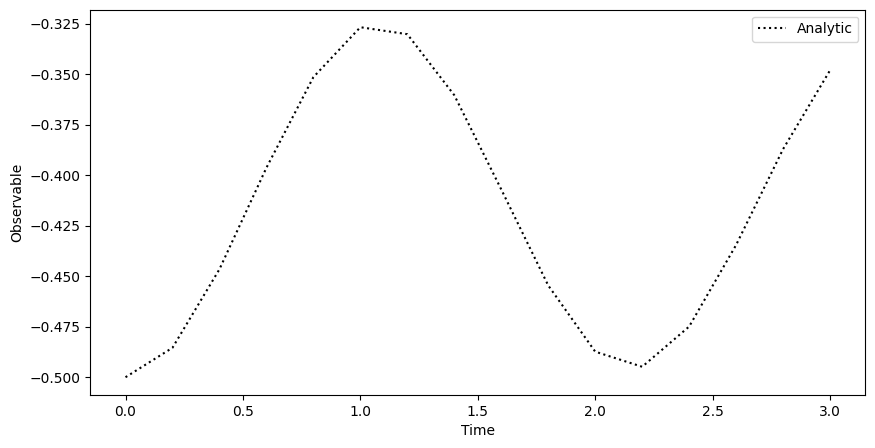

In [160]:
plt.figure(figsize=(10,5))
#plt.plot(time_step_list_exact, exact_cc_n4_g1, 'k:',label='Analytic')
plt.plot(time_step_list_exact, exact_cc_n4_g1, 'k:',label='Analytic')
plt.xlabel('Time')
plt.ylabel('Observable')
plt.legend()
#plt.title('Gate-based time evolution of $\{N_s,M,p\}$={'+str(Ns)+','+str(M)+','+str(p)+'}, $\{\Delta,\omega,g\}$={'+str(delta)+', '+str(omega)+', '+str(g)+'}' )
plt.show()

Let's do this using the simpler built-in functionality in Qiskit.

In [113]:
from qiskit.dagcircuit import DAGCircuit
from qiskit.circuit import QuantumCircuit, QuantumRegister, Gate
from qiskit.circuit.library import CXGate, ECRGate
from qiskit.transpiler import PassManager
from qiskit.transpiler.basepasses import TransformationPass
from qiskit.quantum_info import Operator, pauli_basis
 
import numpy as np
 
from typing import Iterable, Optional

In [161]:
### parameters
N=4
n_site = N
t=0
ti=0
m=1
a=1
g=1

backend = provider.get_backend("ibm_rensselaer")
shots = 10000

Local_Ham = Ham_Schwinger_Pauli(N, 0, 0, m, a, g)

t_start = 0
t_max = 3
dt = 0.2
time_step_list = np.linspace(t_start, t_max, (int((t_max - t_start)/dt))+1)

virtual_pub_list = []
virtual_pub_list_elec_field = []
pub_list = []
pub_list_elec_field = []
tcirc_depth = []

observable_cc = (1/(2*a*N))*Ham_Schwinger_Mass_Pauli(N)
#observable_ldyn = (1/(2*a))*Ldyn_Pauli(N, N-1)
#observable_ldyn = (1/(2*a))*Ldyn_Pauli(N, 1)
observable_elec_field = (1/(2*a))*Ham_Schwinger_Elec_Pauli_Unsquared(N, 0, 0, a)

#time_step_list = np.linspace(0, 3, 61)

circuit = QuantumCircuit(N, N)
# prepare the initial state
for i in range(int(N/2)):
    circuit.x([2*i])

for t in time_step_list:
    print("t = ", t)
    evo_op = PauliEvolutionGate(Local_Ham, dt, synthesis=SuzukiTrotter(order=2, reps=1))
    circuit.append(evo_op.definition, list(range(N)))

    # For doing a simulation using Aer_Sim 
    virtual_pub_list.append((circuit.decompose().decompose(), observable_cc))
    virtual_pub_list_elec_field.append((circuit.decompose().decompose(), observable_elec_field))

    # For actual hardware
    pm = generate_preset_pass_manager(backend=backend, optimization_level=3)
    pm_circuit = pm.run(circuit)
    pm_corr = observable_cc.apply_layout(pm_circuit.layout)
    pm_elec_field = observable_elec_field.apply_layout(pm_circuit.layout)
    pub_list.append((pm_circuit, pm_corr))
    pub_list_elec_field.append((pm_circuit, pm_elec_field))

t =  0.0
t =  0.2
t =  0.4
t =  0.6000000000000001
t =  0.8
t =  1.0
t =  1.2000000000000002
t =  1.4000000000000001
t =  1.6
t =  1.8
t =  2.0
t =  2.2
t =  2.4000000000000004
t =  2.6
t =  2.8000000000000003
t =  3.0


In [85]:
from qiskit_ibm_runtime import EstimatorV2 as Estimator
from qiskit_aer import AerSimulator
aer_sim = AerSimulator()
backend = provider.get_backend("ibm_rensselaer")

estimator = Estimator(backend=backend) # run on actual hardware
#estimator.options.resilience.zne_mitigation = True
#estimator.options.resilience.zne.noise_factors = (1, 3, 5)
#estimator.options.resilience.zne.extrapolator = "exponential"
#estimator.options.dynamical_decoupling.enable = True
#estimator.options.dynamical_decoupling.sequence_type = "XpXm"
#estimator.options.twirling.enable_gates = True
#estimator.options.twirling.num_randomizations = 32
#estimator.options.twirling.shots_per_randomization = 100
shots = 10000

job_cc = estimator.run(pub_list, precision=1/np.sqrt(shots))

result_cc = job_cc.result()

cc_values = [result_cc[i].data.evs for i in range(len(pub_list))]

KeyboardInterrupt: 

In [162]:
from qiskit_aer import AerSimulator
aer_sim = AerSimulator(method='statevector')

sim_estimator = Estimator(backend=aer_sim) # run on simulator

sim_job = sim_estimator.run(virtual_pub_list, precision=1/np.sqrt(shots))
sim_job_elec_field = sim_estimator.run(virtual_pub_list_elec_field, precision=1/np.sqrt(shots))

sim_result = sim_job.result()
sim_result_elec_field = sim_job_elec_field.result()

sim_mag_values = [sim_result[i].data.evs for i in range(len(pub_list))]
sim_values_elec_field = [sim_result_elec_field[i].data.evs for i in range(len(pub_list_elec_field))]

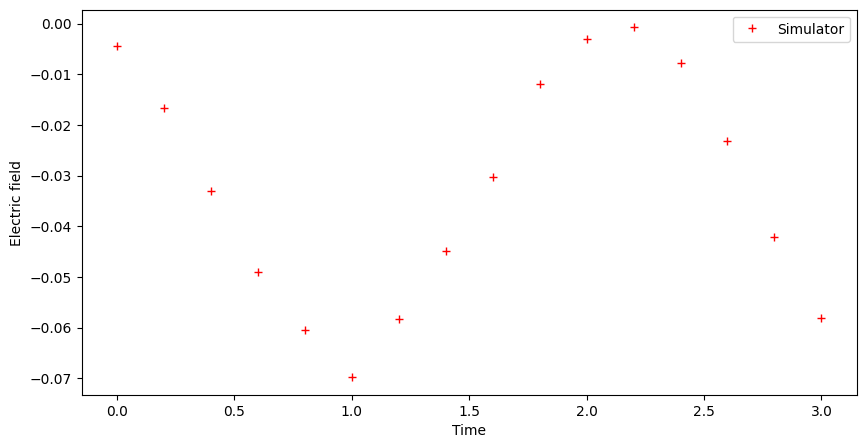

In [138]:
plt.figure(figsize=(10,5))
#plt.plot(time_step_list, cc_values, 'b*',label='ibm_rennselaer')
plt.plot(time_step_list, sim_values_elec_field, 'r+',label='Simulator')
plt.xlabel('Time')
plt.ylabel('Electric field')
plt.legend()
#plt.title('Gate-based time evolution of $\{N_s,M,p\}$={'+str(Ns)+','+str(M)+','+str(p)+'}, $\{\Delta,\omega,g\}$={'+str(delta)+', '+str(omega)+', '+str(g)+'}' )
plt.show()

## Now let's do by hand

In [125]:
# Model parameters
N = 2
m = 1
a = 1
g = 0
J = 0.5*g*g*a

# Backend parameters
#backend = AerSimulator()
backend = provider.get_backend("ibm_rensselaer")
t_start = 0
t_max = 3
dt = 0.2
shots = 10000
time_step_max = int(t_max/dt)
#time_step_list = np.linspace(t_start, t_max, (int((t_max - t_start)/dt))+1)

# quantum and measurement circuits
qr = QuantumRegister(N)
cr = ClassicalRegister(N)
qc = QuantumCircuit(qr,cr)
qc_meas = QuantumCircuit(qr,cr)
qc_meas.measure(qr,cr)

# initial state prep
for i in range(int(N/2)):
  qc.x(qr[2*i+1])

time_list = []
cc_list_n2_g0_a = []
elec_list_n2_g0 = []
circuit_depth_list = []

for time_step in range(time_step_max+1):
    print("Time = ", dt*time_step)

    # H_{XX+YY} kinetic term
    for i in range(N-1):
        qc.cx(qr[i], qr[i+1])
        qc.h(qr[i])
        qc.cx(qr[i], qr[i+1])

        qc.rz((0.5/a)*dt, qr[i])
        qc.rz(-(0.5/a)*dt, qr[i+1])

        qc.cx(qr[i], qr[i+1])
        qc.h(qr[i])
        qc.cx(qr[i], qr[i+1])

    # H_Z mass term
    for i in range(N):
        qc.rz(m*((-1)**(i+1))*dt, qr[i])

    # H_ZZ electric field term
    for i in range(1, N-1):
        for k in range(0, i):
            for l in range(k+1, i+1):
                qc.rzz(J*dt, qr[k], qr[l])

    # H_Z electric field term
    for n in range(N-1):
        qc.rz(-0.5*J*dt*(N-(n+1)-0.5*(-1+(-1)**(n+1))), qr[n])

    # transpile circuit, calculate 2-gate depth, run job on hardware
    qc_total = qc.compose(qc_meas)
    qc_trans = transpile(qc_total.decompose().decompose(), backend=backend, optimization_level=3, initial_layout=[0,1])
    circuit_depth_list.append(qc_trans.depth(lambda x: x[0].name=="ecr"))
    job = backend.run(qc_trans, shots=shots)

    result = job.result() 
    counts = result.get_counts()

    # calculate observables
    cc = 0
    ef = 0

    for bit_string, count in counts.items():
        obs = 0
        obs_elec_field = 0
        bit_string_be = bit_string[::-1] 
                                         
        for j in range(N):
            obs += (-1)**int(bit_string_be[j])*(-1)**(j+1)
            obs_elec_field += (-1)**int(bit_string_be[j])*(N-(j+1)-0.5*(-1+(-1)**(j+1)))*0.5
        cc += obs*count/shots/(2*a*N)
        ef += obs_elec_field*count/shots/(2*a*N)

    time_list.append(dt*time_step) 
    cc_list_n2_g0_a.append(cc)
    elec_list_n2_g0.append(-0.25+ef)

Time =  0.0
Time =  0.2
Time =  0.4
Time =  0.6000000000000001
Time =  0.8
Time =  1.0
Time =  1.2000000000000002
Time =  1.4000000000000001
Time =  1.6
Time =  1.8
Time =  2.0
Time =  2.2
Time =  2.4000000000000004
Time =  2.6
Time =  2.8000000000000003
Time =  3.0


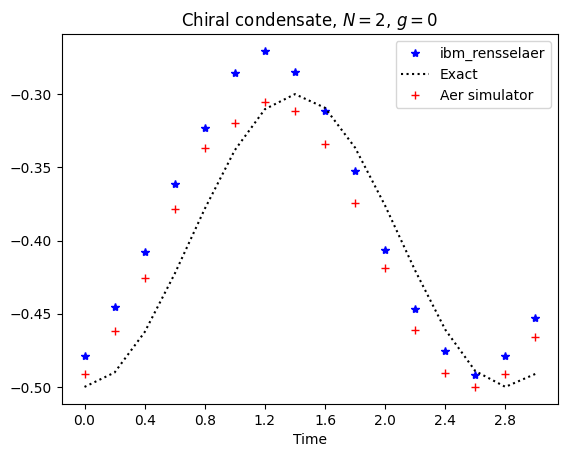

In [131]:
# Chiral condensate N=2 g=0
plt.plot(time_list, cc_list_n2_g0_a, 'b*', label='ibm_rensselaer')
plt.plot(time_step_list, exact_cc_n2_g0, 'k:',label='Exact')
#plt.plot(time_list, cc_list, 'b*', label='ibm_rensselaer by hand')
#plt.plot(time_step_list, cc_values, 'k*',label='ibm_rennselaer PEG')
plt.plot(time_step_list, sim_mag_values, 'r+',label='Aer simulator')
plt.xlabel('Time')
plt.xticks(np.arange(min(time_list), max(time_list)+0.2, 0.4))
plt.title(r'Chiral condensate, $N=2$, $g=0$')
plt.legend()
plt.show()

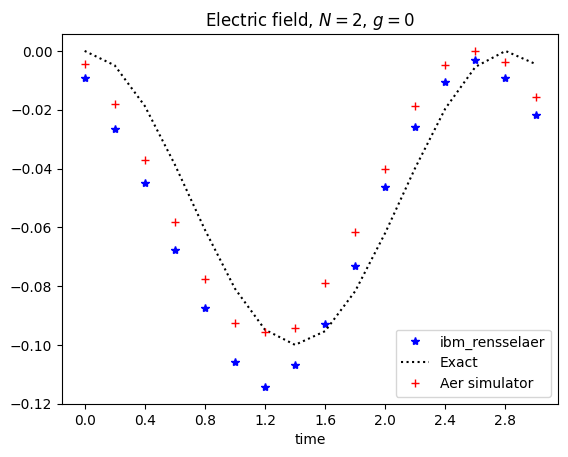

In [148]:
# Electric field N=2 g=0
plt.plot(time_list, elec_list_n2_g0, 'b*', label='ibm_rensselaer')
#plt.plot(time_list, elec_list_n2_g0, 'b*', label='ibm_rensselaer')
plt.plot(time_step_list, exact_Elec_Field_n2_g0, 'k:',label='Exact')
#plt.plot(time_list, cc_list, 'b*', label='ibm_rensselaer by hand')
#plt.plot(time_step_list, cc_values, 'k*',label='ibm_rennselaer PEG')
plt.plot(time_step_list, sim_values_elec_field, 'r+',label='Aer simulator')
plt.xlabel('time')
plt.xticks(np.arange(min(time_list), max(time_list)+0.2, 0.4))
plt.title(r'Electric field, $N=2$, $g=0$')
plt.legend()
plt.show()

In [130]:
# Model parameters
N = 2
m = 1
a = 1
g = 1
J = 0.5*g*g*a

# Backend parameters
#backend = AerSimulator()
backend = provider.get_backend("ibm_rensselaer")
t_start = 0
t_max = 3
dt = 0.2
shots = 10000
time_step_max = int(t_max/dt)
#time_step_list = np.linspace(t_start, t_max, (int((t_max - t_start)/dt))+1)

# quantum and measurement circuits
qr = QuantumRegister(N)
cr = ClassicalRegister(N)
qc = QuantumCircuit(qr,cr)
qc_meas = QuantumCircuit(qr,cr)
qc_meas.measure(qr,cr)

# initial state prep
for i in range(int(N/2)):
  qc.x(qr[2*i+1])

time_list = []
cc_list_n2_g1 = []
elec_list_n2_g1 = []
circuit_depth_list = []

for time_step in range(time_step_max+1):
    print("Time = ", dt*time_step)

    # H_{XX+YY} kinetic term
    for i in range(N-1):
        qc.cx(qr[i], qr[i+1])
        qc.h(qr[i])
        qc.cx(qr[i], qr[i+1])

        qc.rz((0.5/a)*dt, qr[i])
        qc.rz(-(0.5/a)*dt, qr[i+1])

        qc.cx(qr[i], qr[i+1])
        qc.h(qr[i])
        qc.cx(qr[i], qr[i+1])

    # H_Z mass term
    for i in range(N):
        qc.rz(m*((-1)**(i+1))*dt, qr[i])

    # H_ZZ electric field term
    for i in range(1, N-1):
        for k in range(0, i):
            for l in range(k+1, i+1):
                qc.rzz(J*dt, qr[k], qr[l])

    # H_Z electric field term
    for n in range(N-1):
        qc.rz(-0.5*J*dt*(N-(n+1)-0.5*(-1+(-1)**(n+1))), qr[n])

    # transpile circuit, calculate 2-gate depth, run job on hardware
    qc_total = qc.compose(qc_meas)
    qc_trans = transpile(qc_total.decompose().decompose(), backend=backend, optimization_level=3, initial_layout=[0,1])
    circuit_depth_list.append(qc_trans.depth(lambda x: x[0].name=="ecr"))
    job = backend.run(qc_trans, shots=shots)

    result = job.result() 
    counts = result.get_counts()

    # calculate observables
    cc = 0
    ef = 0

    for bit_string, count in counts.items():
        obs = 0
        obs_elec_field = 0
        bit_string_be = bit_string[::-1] 
                                         
        for j in range(N):
            obs += (-1)**int(bit_string_be[j])*(-1)**(j+1)
            obs_elec_field += (-1)**int(bit_string_be[j])*(N-(j+1)-0.5*(-1+(-1)**(j+1)))*0.5
        cc += obs*count/shots/(2*a*N)
        ef += obs_elec_field*count/shots/(2*a*N)

    time_list.append(dt*time_step) 
    cc_list_n2_g1.append(cc)
    elec_list_n2_g1.append(-0.25+ef)

Time =  0.0
Time =  0.2
Time =  0.4
Time =  0.6000000000000001
Time =  0.8
Time =  1.0
Time =  1.2000000000000002
Time =  1.4000000000000001
Time =  1.6
Time =  1.8
Time =  2.0
Time =  2.2
Time =  2.4000000000000004
Time =  2.6
Time =  2.8000000000000003
Time =  3.0


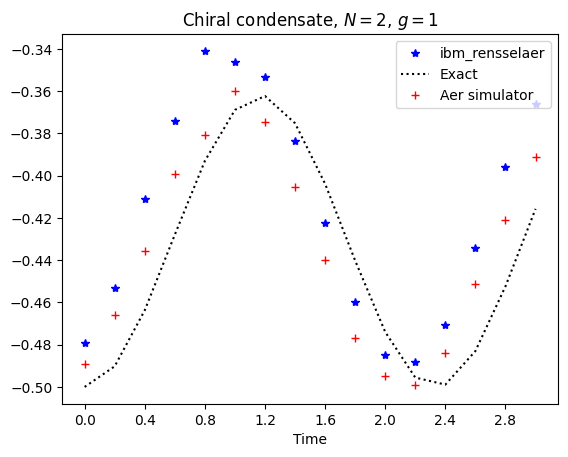

In [139]:
# Chiral condensate N=2 g=1
plt.plot(time_list, cc_list_n2_g1, 'b*', label='ibm_rensselaer')
plt.plot(time_step_list, exact_cc_n2_g1, 'k:',label='Exact')
#plt.plot(time_list, cc_list, 'b*', label='ibm_rensselaer by hand')
#plt.plot(time_step_list, cc_values, 'k*',label='ibm_rennselaer PEG')
plt.plot(time_step_list, sim_mag_values, 'r+',label='Aer simulator')
plt.xlabel('Time')
plt.xticks(np.arange(min(time_list), max(time_list)+0.2, 0.4))
plt.title(r'Chiral condensate, $N=2$, $g=1$')
plt.legend()
plt.show()

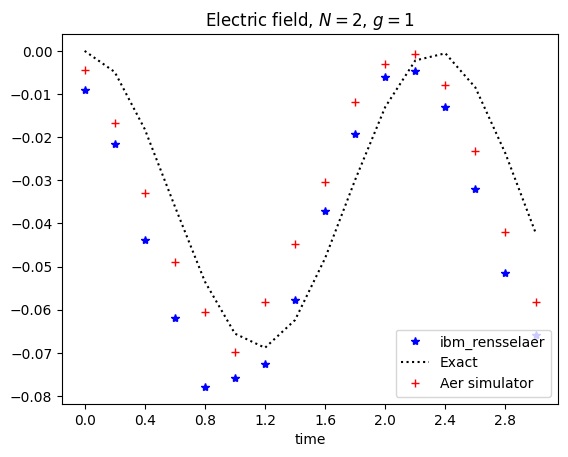

In [143]:
# Electric field N=2 g=1
plt.plot(time_list, elec_list_n2_g1, 'b*', label='ibm_rensselaer')
#plt.plot(time_list, elec_list_n2_g0, 'b*', label='ibm_rensselaer')
plt.plot(time_step_list, exact_Elec_Field_n2_g1, 'k:',label='Exact')
#plt.plot(time_list, cc_list, 'b*', label='ibm_rensselaer by hand')
#plt.plot(time_step_list, cc_values, 'k*',label='ibm_rennselaer PEG')
plt.plot(time_step_list, sim_values_elec_field, 'r+',label='Aer simulator')
plt.xlabel('time')
plt.xticks(np.arange(min(time_list), max(time_list)+0.2, 0.4))
plt.title(r'Electric field, $N=2$, $g=1$')
plt.legend()
plt.show()

# N=4

In [150]:
# Model parameters
N = 4
m = 1
a = 1
g = 0
J = 0.5*g*g*a

# Backend parameters
#backend = AerSimulator()
backend = provider.get_backend("ibm_rensselaer")
t_start = 0
t_max = 3
dt = 0.2
shots = 10000
time_step_max = int(t_max/dt)
#time_step_list = np.linspace(t_start, t_max, (int((t_max - t_start)/dt))+1)

# quantum and measurement circuits
qr = QuantumRegister(N)
cr = ClassicalRegister(N)
qc = QuantumCircuit(qr,cr)
qc_meas = QuantumCircuit(qr,cr)
qc_meas.measure(qr,cr)

# initial state prep
for i in range(int(N/2)):
  qc.x(qr[2*i+1])

time_list = []
cc_list_n4_g0 = []
elec_list_n4_g0 = []
circuit_depth_list = []

for time_step in range(time_step_max+1):
    print("Time = ", dt*time_step)

    # H_{XX+YY} kinetic term
    for i in range(N-1):
        qc.cx(qr[i], qr[i+1])
        qc.h(qr[i])
        qc.cx(qr[i], qr[i+1])

        qc.rz((0.5/a)*dt, qr[i])
        qc.rz(-(0.5/a)*dt, qr[i+1])

        qc.cx(qr[i], qr[i+1])
        qc.h(qr[i])
        qc.cx(qr[i], qr[i+1])

    # H_Z mass term
    for i in range(N):
        qc.rz(m*((-1)**(i+1))*dt, qr[i])

    # H_ZZ electric field term
    for i in range(1, N-1):
        for k in range(0, i):
            for l in range(k+1, i+1):
                qc.rzz(J*dt, qr[k], qr[l])

    # H_Z electric field term
    for n in range(N-1):
        qc.rz(-0.5*J*dt*(N-(n+1)-0.5*(-1+(-1)**(n+1))), qr[n])

    # transpile circuit, calculate 2-gate depth, run job on hardware
    qc_total = qc.compose(qc_meas)
    qc_trans = transpile(qc_total.decompose().decompose(), backend=backend, optimization_level=3, initial_layout=[0,1,2,3])
    circuit_depth_list.append(qc_trans.depth(lambda x: x[0].name=="ecr"))
    job = backend.run(qc_trans, shots=shots)

    result = job.result() 
    counts = result.get_counts()

    # calculate observables
    cc = 0
    ef = 0

    for bit_string, count in counts.items():
        obs = 0
        obs_elec_field = 0
        bit_string_be = bit_string[::-1] 
                                         
        for j in range(N):
            obs += (-1)**int(bit_string_be[j])*(-1)**(j+1)
            obs_elec_field += (-1)**int(bit_string_be[j])*(N-(j+1)-0.5*(-1+(-1)**(j+1)))*0.5
        cc += obs*count/shots/(2*a*N)
        ef += obs_elec_field*count/shots/(2*a*N)

    time_list.append(dt*time_step) 
    cc_list_n4_g0.append(cc)
    elec_list_n4_g0.append(-0.25+ef)

Time =  0.0
Time =  0.2
Time =  0.4
Time =  0.6000000000000001
Time =  0.8
Time =  1.0
Time =  1.2000000000000002
Time =  1.4000000000000001
Time =  1.6
Time =  1.8
Time =  2.0
Time =  2.2
Time =  2.4000000000000004
Time =  2.6
Time =  2.8000000000000003
Time =  3.0


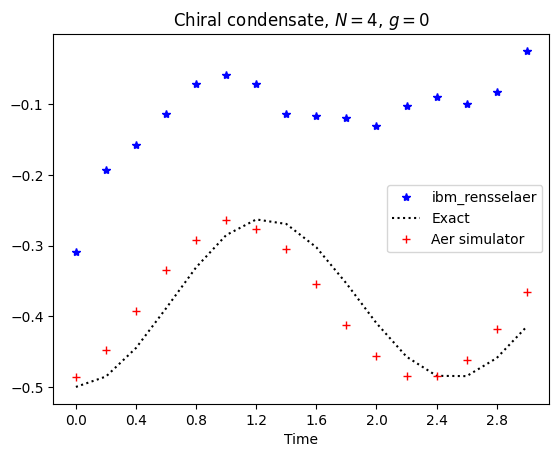

In [155]:
# Chiral condensate N=4 g=0
plt.plot(time_list, cc_list_n4_g0, 'b*', label='ibm_rensselaer')
plt.plot(time_step_list, exact_cc_n4_g0, 'k:',label='Exact')
#plt.plot(time_list, cc_list, 'b*', label='ibm_rensselaer by hand')
#plt.plot(time_step_list, cc_values, 'k*',label='ibm_rennselaer PEG')
plt.plot(time_step_list, sim_mag_values, 'r+',label='Aer simulator')
plt.xlabel('Time')
plt.xticks(np.arange(min(time_list), max(time_list)+0.2, 0.4))
plt.title(r'Chiral condensate, $N=4$, $g=0$')
plt.legend()
plt.show()

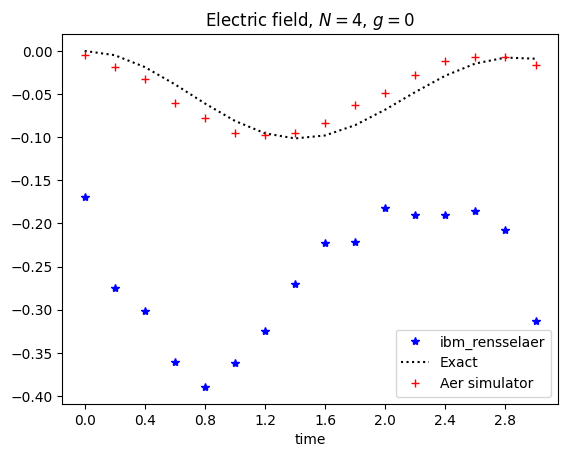

In [156]:
# Electric field N=4 g=0
plt.plot(time_list, elec_list_n4_g0, 'b*', label='ibm_rensselaer')
#plt.plot(time_list, elec_list_n4_g0, 'b*', label='ibm_rensselaer')
plt.plot(time_step_list, exact_Elec_Field_n4_g0, 'k:',label='Exact')
#plt.plot(time_list, cc_list, 'b*', label='ibm_rensselaer by hand')
#plt.plot(time_step_list, cc_values, 'k*',label='ibm_rennselaer PEG')
plt.plot(time_step_list, sim_values_elec_field, 'r+',label='Aer simulator')
plt.xlabel('time')
plt.xticks(np.arange(min(time_list), max(time_list)+0.2, 0.4))
plt.title(r'Electric field, $N=4$, $g=0$')
plt.legend()
plt.show()

In [158]:
# Model parameters
N = 4
m = 1
a = 1
g = 1
J = 0.5*g*g*a

# Backend parameters
#backend = AerSimulator()
backend = provider.get_backend("ibm_rensselaer")
t_start = 0
t_max = 3
dt = 0.2
shots = 10000
time_step_max = int(t_max/dt)
#time_step_list = np.linspace(t_start, t_max, (int((t_max - t_start)/dt))+1)

# quantum and measurement circuits
qr = QuantumRegister(N)
cr = ClassicalRegister(N)
qc = QuantumCircuit(qr,cr)
qc_meas = QuantumCircuit(qr,cr)
qc_meas.measure(qr,cr)

# initial state prep
for i in range(int(N/2)):
  qc.x(qr[2*i+1])

time_list = []
cc_list_n4_g1 = []
elec_list_n4_g1 = []
circuit_depth_list = []

for time_step in range(time_step_max+1):
    print("Time = ", dt*time_step)

    # H_{XX+YY} kinetic term
    for i in range(N-1):
        qc.cx(qr[i], qr[i+1])
        qc.h(qr[i])
        qc.cx(qr[i], qr[i+1])

        qc.rz((0.5/a)*dt, qr[i])
        qc.rz(-(0.5/a)*dt, qr[i+1])

        qc.cx(qr[i], qr[i+1])
        qc.h(qr[i])
        qc.cx(qr[i], qr[i+1])

    # H_Z mass term
    for i in range(N):
        qc.rz(m*((-1)**(i+1))*dt, qr[i])

    # H_ZZ electric field term
    for i in range(1, N-1):
        for k in range(0, i):
            for l in range(k+1, i+1):
                qc.rzz(J*dt, qr[k], qr[l])

    # H_Z electric field term
    for n in range(N-1):
        qc.rz(-0.5*J*dt*(N-(n+1)-0.5*(-1+(-1)**(n+1))), qr[n])

    # transpile circuit, calculate 2-gate depth, run job on hardware
    qc_total = qc.compose(qc_meas)
    qc_trans = transpile(qc_total.decompose().decompose(), backend=backend, optimization_level=3, initial_layout=[0,1,2,3])
    circuit_depth_list.append(qc_trans.depth(lambda x: x[0].name=="ecr"))
    job = backend.run(qc_trans, shots=shots)

    result = job.result() 
    counts = result.get_counts()

    # calculate observables
    cc = 0
    ef = 0

    for bit_string, count in counts.items():
        obs = 0
        obs_elec_field = 0
        bit_string_be = bit_string[::-1] 
                                         
        for j in range(N):
            obs += (-1)**int(bit_string_be[j])*(-1)**(j+1)
            obs_elec_field += (-1)**int(bit_string_be[j])*(N-(j+1)-0.5*(-1+(-1)**(j+1)))*0.5
        cc += obs*count/shots/(2*a*N)
        ef += obs_elec_field*count/shots/(2*a*N)

    time_list.append(dt*time_step) 
    cc_list_n4_g1.append(cc)
    elec_list_n4_g1.append(-0.25+ef)

Time =  0.0
Time =  0.2
Time =  0.4
Time =  0.6000000000000001
Time =  0.8
Time =  1.0
Time =  1.2000000000000002
Time =  1.4000000000000001
Time =  1.6
Time =  1.8
Time =  2.0
Time =  2.2
Time =  2.4000000000000004
Time =  2.6
Time =  2.8000000000000003
Time =  3.0


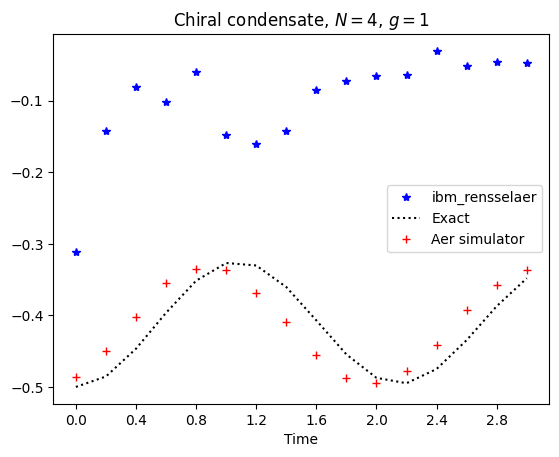

In [166]:
# Chiral condensate N=4 g=1
plt.plot(time_list, cc_list_n4_g1, 'b*', label='ibm_rensselaer')
plt.plot(time_step_list, exact_cc_n4_g1, 'k:',label='Exact')
#plt.plot(time_list, cc_list, 'b*', label='ibm_rensselaer by hand')
#plt.plot(time_step_list, cc_values, 'k*',label='ibm_rennselaer PEG')
plt.plot(time_step_list, sim_mag_values, 'r+',label='Aer simulator')
plt.xlabel('Time')
plt.xticks(np.arange(min(time_list), max(time_list)+0.2, 0.4))
plt.title(r'Chiral condensate, $N=4$, $g=1$')
plt.legend()
plt.show()

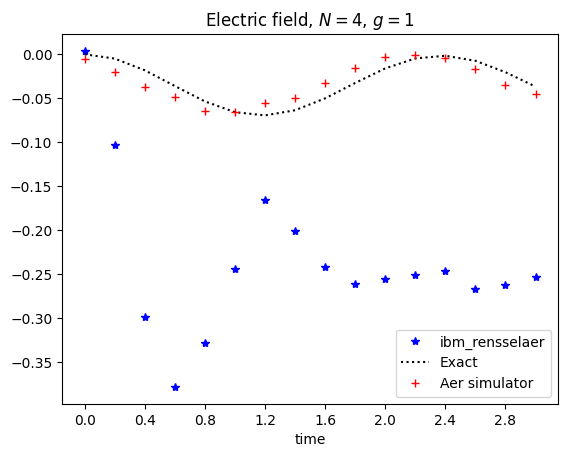

In [165]:
# Electric field N=4 g=1
plt.plot(time_list, elec_list_n4_g1, 'b*', label='ibm_rensselaer')
#plt.plot(time_list, elec_list_n4_g0, 'b*', label='ibm_rensselaer')
plt.plot(time_step_list, exact_Elec_Field_n4_g1, 'k:',label='Exact')
#plt.plot(time_list, cc_list, 'b*', label='ibm_rensselaer by hand')
#plt.plot(time_step_list, cc_values, 'k*',label='ibm_rennselaer PEG')
plt.plot(time_step_list, sim_values_elec_field, 'r+',label='Aer simulator')
plt.xlabel('time')
plt.xticks(np.arange(min(time_list), max(time_list)+0.2, 0.4))
plt.title(r'Electric field, $N=4$, $g=1$')
plt.legend()
plt.show()

# Scratch

Text(0.5, 1.0, 'Two-qubit circuit depth as function of time steps (N=4, g=0)')

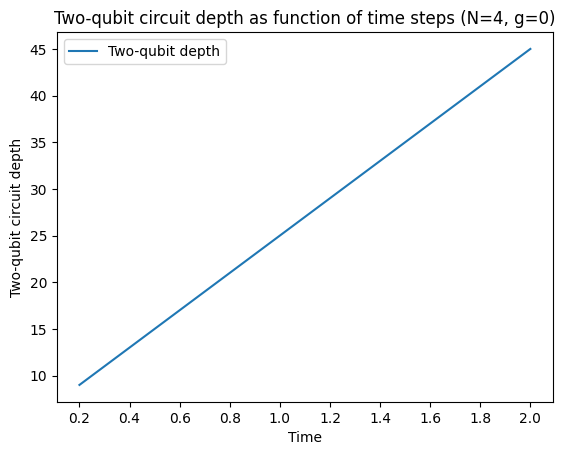

In [402]:
import matplotlib.pyplot as plt
#plt.plot(nlist, [e for e in depth_list], label='Circuit depth')
plt.plot(time_list, [e for e in circuit_depth], label='Two-qubit depth')
plt.xlabel(r'Time')
plt.ylabel('Two-qubit circuit depth')
plt.xticks(np.arange(min(time_list), max(time_list)+0.2, .2))
#plt.xscale('log',base=2) 
#plt.yscale('log',base=2) 
plt.legend()
plt.title(r'Two-qubit circuit depth as function of time steps (N=4, g=0)')